In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import os

In [2]:
#load data
os.chdir('../..')
df=pd.read_csv('./data/csv/graph-features-reduced.csv')
#drop node and cluster columns
df.drop(['node','cluster'],axis=1,inplace=True)
#train logistic regression model with all numerical features
classif = setup(data = df, target = 'label', session_id=123, train_size=0.7,numeric_features=['ID','OD','IDW','ODW','LCC','AC','BC'],silent=True)

,Description,Value
0,session_id,123
1,Target,label
2,Target Type,Binary
3,Label Encoded,"botnet: 0, normal: 1"
4,Original Data,"(18693, 8)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [3]:
#add balanced accuracy metric
add_metric('balanced_accuracy', 'Balanced Accuracy', balanced_accuracy_score, greater_is_better=True)

#Add specificity metric
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity
    
add_metric('specificity', 'Specificity', specificity_score, greater_is_better=True)



Name                                                    Specificity
Display Name                                            Specificity
Score Function       <function specificity_score at 0x7f04507c0790>
Scorer                               make_scorer(specificity_score)
Target                                                         pred
Args                                                             {}
Greater is Better                                              True
Multiclass                                                     True
Custom                                                         True
Name: specificity, dtype: object

In [4]:
#logistic regression without penalization
lr = create_model('lr',penalty='none',class_weight='balanced')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy,Specificity
Fold,,,,,,,,,
0,0.1230,0.5547,0.1224,0.9938,0.2180,-0.0013,-0.0449,0.3112,0.5000
1,0.1131,0.5471,0.1125,0.9932,0.2021,-0.0013,-0.0478,0.3062,0.5000
2,0.2162,0.5126,0.2158,0.9965,0.3547,-0.0011,-0.0270,0.3579,0.5000
3,0.1459,0.5134,0.1454,0.9948,0.2537,-0.0013,-0.0392,0.3227,0.5000
4,0.0940,0.9954,0.0926,1.0000,0.1695,0.0003,0.0125,0.5463,1.0000
5,0.0107,0.5555,0.0099,1.0000,0.0197,0.0000,0.0028,0.5050,1.0000
6,0.1789,0.9923,0.1783,1.0000,0.3026,0.0003,0.0129,0.5891,1.0000
7,0.1476,0.9885,0.1469,1.0000,0.2562,0.0003,0.0115,0.5735,1.0000
8,0.1628,0.9901,0.1622,1.0000,0.2791,0.0003,0.0122,0.5811,1.0000


In [5]:
lr_results=pull()
#gthe dataframe has a column called Recall and a row called Mean. I want the value in the cell
lr_recall=lr_results.loc['Mean','Specificity']
print(lr_recall)
lr_results

0.8


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy,Specificity
Fold,,,,,,,,,
0,0.1230,0.5547,0.1224,0.9938,0.2180,-0.0013,-0.0449,0.3112,0.5000
1,0.1131,0.5471,0.1125,0.9932,0.2021,-0.0013,-0.0478,0.3062,0.5000
2,0.2162,0.5126,0.2158,0.9965,0.3547,-0.0011,-0.0270,0.3579,0.5000
3,0.1459,0.5134,0.1454,0.9948,0.2537,-0.0013,-0.0392,0.3227,0.5000
4,0.0940,0.9954,0.0926,1.0000,0.1695,0.0003,0.0125,0.5463,1.0000
5,0.0107,0.5555,0.0099,1.0000,0.0197,0.0000,0.0028,0.5050,1.0000
6,0.1789,0.9923,0.1783,1.0000,0.3026,0.0003,0.0129,0.5891,1.0000
7,0.1476,0.9885,0.1469,1.0000,0.2562,0.0003,0.0115,0.5735,1.0000
8,0.1628,0.9901,0.1622,1.0000,0.2791,0.0003,0.0122,0.5811,1.0000


In [6]:
#Save logistic regression average and stdev metrics
lr_results = pull()
#Keep Recall, Balanced Accuracy and specificity columns only
lr_results = lr_results[['Recall','Balanced Accuracy','Specificity']]
#Save dataframe rows called Mean and Std
lr_results = lr_results.loc[['Mean','Std']]
lr_results

,Recall,Balanced Accuracy,Specificity
Fold,,,
Mean,0.1198,0.4599,0.8000
Std,0.0634,0.1144,0.2449


In [21]:
max_features=[1,2,3,4,5,6]
max_depth=[1,2,3,4,5,6]
n_estimators=[10,100]
#create dataframe for storing results
results=pd.DataFrame(columns=['max_features','max_depth','n_estimators','recall_mean','recall_stdev','specificity_mean','specificity_std','balanced_acc_mean','balanced_acc_std'])
for feat in max_features:
    for depth in max_depth:
        for est in n_estimators:
            rf=create_model('rf',max_features=feat,max_depth=depth,n_estimators=est)#class_weight='balanced' if unbalanced works bad
            #To train on unbalanced data use class_weight='balanced'
            rf_results=pull()
            rf_recall_mean=rf_results.loc['Mean','Recall']
            rf_recall_stdev=rf_results.loc['Std','Recall']
            rf_specificity_mean=rf_results.loc['Mean','Specificity']
            rf_specificity_stdev=rf_results.loc['Std','Specificity']
            rf_balanced_acc_mean=rf_results.loc['Mean','Balanced Accuracy']
            rf_balanced_acc_stdev=rf_results.loc['Std','Balanced Accuracy']           
            
            #store results
            results=results.append({'max_features':feat,'max_depth':depth,'n_estimators':est,'recall_mean':rf_recall_mean,'recall_stdev':rf_recall_stdev,'specificity_mean':rf_specificity_mean,'specificity_std':rf_specificity_stdev,'balanced_acc_mean':rf_balanced_acc_mean,'balanced_acc_std':rf_balanced_acc_stdev},ignore_index=True)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy,Specificity
Fold,,,,,,,,,
0,0.9992,0.9899,1.0000,0.9992,0.9996,0.6663,0.7068,0.7500,0.5000
1,0.9992,0.9996,1.0000,0.9992,0.9996,0.6663,0.7068,0.7500,0.5000
2,0.9992,0.9977,1.0000,0.9992,0.9996,0.6663,0.7068,0.7500,0.5000
3,0.9985,0.4851,1.0000,0.9985,0.9992,0.0000,0.0000,0.5000,0.0000
4,0.9992,0.9983,1.0000,0.9992,0.9996,0.6663,0.7068,0.7500,0.5000
5,0.9992,0.9728,1.0000,0.9992,0.9996,0.0000,0.0000,0.5000,0.0000
6,0.9992,1.0000,1.0000,0.9992,0.9996,0.0000,0.0000,0.5000,0.0000
7,0.9992,0.9927,1.0000,0.9992,0.9996,0.0000,0.0000,0.5000,0.0000
8,0.9992,0.9901,1.0000,0.9992,0.9996,0.0000,0.0000,0.5000,0.0000


In [22]:
results

,max_features,max_depth,n_estimators,recall_mean,recall_stdev,specificity_mean,specificity_std,balanced_acc_mean,balanced_acc_std
0,1.0,1.0,10.0,1.0000,0.0000,0.0,0.0000,0.5000,0.0000
1,1.0,1.0,100.0,1.0000,0.0000,0.0,0.0000,0.5000,0.0000
2,1.0,2.0,10.0,1.0000,0.0000,0.0,0.0000,0.5000,0.0000
3,1.0,2.0,100.0,1.0000,0.0000,0.0,0.0000,0.5000,0.0000
4,1.0,3.0,10.0,1.0000,0.0000,0.0,0.0000,0.5000,0.0000
...,...,...,...,...,...,...,...,...,...
67,6.0,4.0,100.0,1.0000,0.0000,0.3,0.3317,0.6500,0.1658
68,6.0,5.0,10.0,0.9999,0.0002,0.3,0.3317,0.6500,0.1659
69,6.0,5.0,100.0,1.0000,0.0000,0.3,0.3317,0.6500,0.1658
70,6.0,6.0,10.0,0.9998,0.0005,0.3,0.3317,0.6499,0.1657


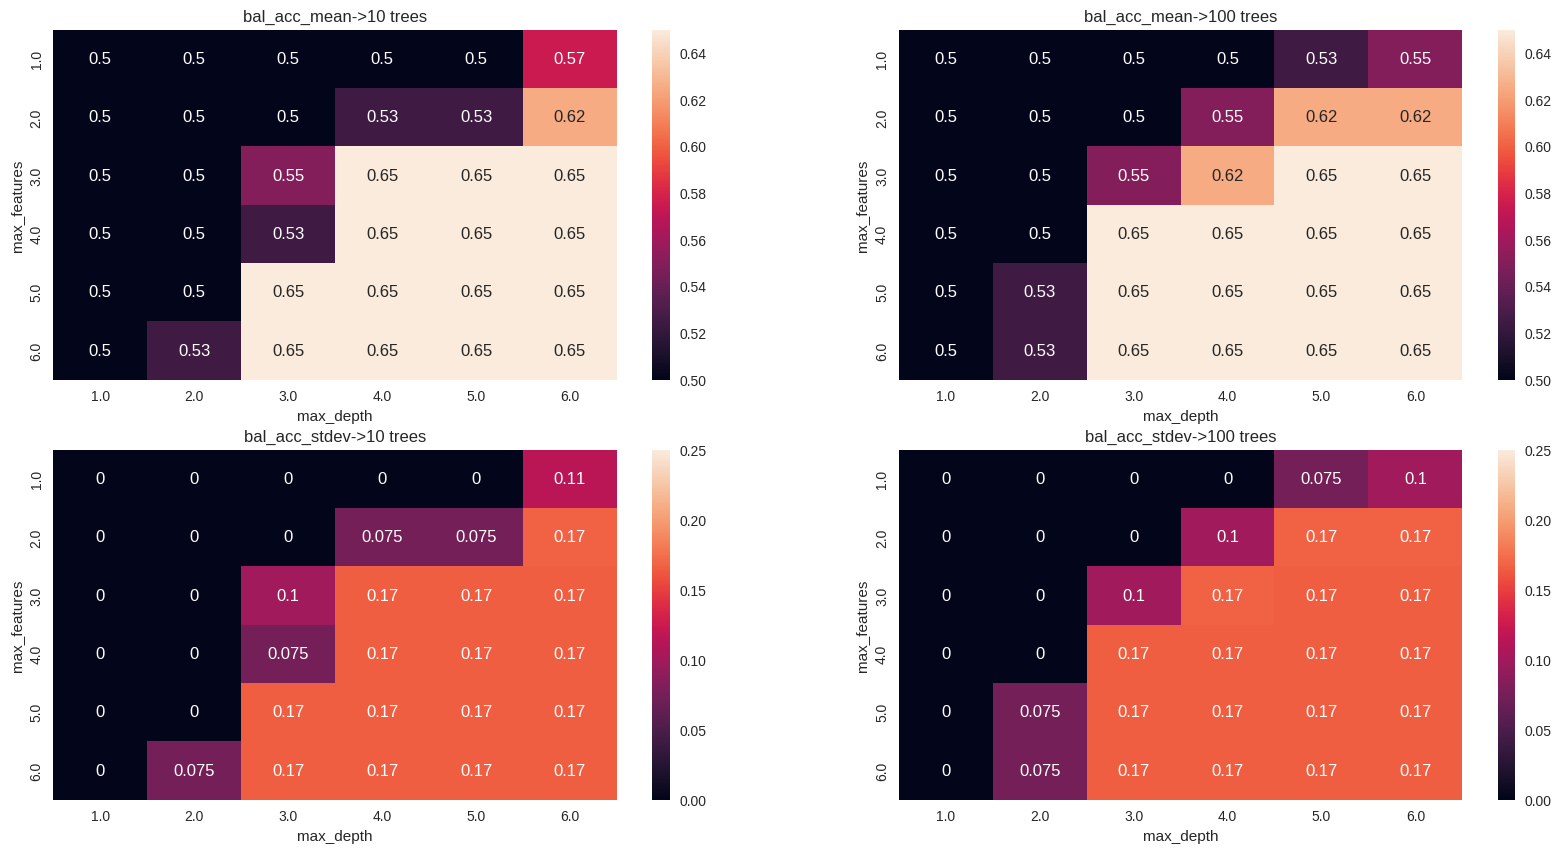

In [23]:
#A good way to visualize a 2 dimensional grid is to use a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

#Creat a 2x5 plot of heatmaps with balanced accuracy mean and stdev for each of the 5 n_estimator values
fig, axs = plt.subplots(2,2,figsize=(20,10))
for i in range(0,2): 
    sns.heatmap(results[results['n_estimators']==n_estimators[i]].pivot(index='max_features',columns='max_depth',values='balanced_acc_mean'),ax=axs[0,i],annot=True)
    axs[0,i].set_title('bal_acc_mean->'+str(n_estimators[i])+' trees')
    sns.heatmap(results[results['n_estimators']==n_estimators[i]].pivot(index='max_features',columns='max_depth',values='balanced_acc_std'),ax=axs[1,i],annot=True,vmin=0,vmax=0.25)
    axs[1,i].set_title('bal_acc_stdev->'+str(n_estimators[i])+' trees')
plt.show()
# #Create a pivot table with the results
# pivot=results.pivot(index='max_features',columns='max_depth',values='balanced_acc_mean')
# #Make 2x2 heatmaps plot
# fig, ax = plt.subplots(2,2,figsize=(10,10))

# #Plot the pivot table
# sns.heatmap(pivot,annot=True)
# plt.title('Balanced Accuracy,'+)
# plt.show()

In [ ]:
results.to_csv('./data/csv/rf_results.csv',index=False)